# Open Street Map

### How a cultural mega event effects city life
### Documenta, Kassel
    
* the 'Documenta' is one of the biggest art exhibitions worldwide (it is open for 100 days)
* it happens every 5 years in Kassel, Germany (the city where I did my Psychology MSc and BSc)
* While Kassel hast 200.000 inhabitants, the Documenta attracts 900.000 visitors during the 100 days of exhibition - city life is transformed!
* from each of the past 14 Documentas, you can find urban traces - permanent installations that became sights, new bars, cafes, cultural centres, ...
* I'd like to find these traces / urban changes in OSM data (the last Documenta 14 was in 2017)

In [1]:
# Current OSM data to find cultural nodes in Kassel

# define a function to query OSM data
# using overpass API 

import requests
import json
import pandas as pd

def getObjects(x):
    overpass_url = "http://overpass-api.de/api/interpreter"
    try:
        overpass_query = """
        [out:json];
        area[name="Kassel"][type="boundary"];
        (node["amenity"={}](area);
        way["amenity"={}](area);
        rel["amenity"={}](area);
        );
        out center;
        """.format(x,x,x)
        response_json = requests.get(overpass_url, params = {'data': overpass_query})
        return response_json
    except:
        pass


objects = ["art_centre", "bar", "cafe", "cinema", "night_club", "social_centre", "theatre"]
alldata = []

for i in objects:
    try:
        response_json = getObjects(i)
        data = response_json.json()
        alldata.append(data)
    except:
        pass

In [2]:
# process output

df_list = []

for i in range(1,7):
    try:
        doc_objects = pd.Series.to_dict(pd.DataFrame(alldata[i]["elements"])["tags"])
        doc_objects_df = pd.DataFrame(doc_objects).T
        df_list.append(doc_objects_df)
    except:
        pass
    
    
doc_df = pd.concat(df_list, sort=True)

display(doc_df["amenity"].value_counts())   

cafe             119
bar               42
theatre           13
cinema             4
social_centre      2
Name: amenity, dtype: int64

In [3]:
# Put coordinates from API output list to list
# this could be done more elegent but this was the easiest way to plot with different colours afterwards

coord_list_cafes = []
coord_list_bars = []
coord_list_theatres = []
coord_list_cinemas = []
coord_list_social_centres = []

for element in alldata[2]['elements']:
    lon = element['lon']
    lat = element['lat']
    coord_list_cafes.append((lon, lat))

for element in alldata[1]['elements']:
    lon = element['lon']
    lat = element['lat']
    coord_list_bars.append((lon, lat))

for element in alldata[6]['elements']:
    lon = element['lon']
    lat = element['lat']
    coord_list_theatres.append((lon, lat))

for element in alldata[3]['elements']:
    lon = element['lon']
    lat = element['lat']
    coord_list_cinemas.append((lon, lat))

for element in alldata[5]['elements']:
    lon = element['lon']
    lat = element['lat']
    coord_list_social_centres.append((lon, lat))

all_coords = coord_list_cafes + coord_list_bars + coord_list_theatres + coord_list_cinemas + coord_list_social_centres

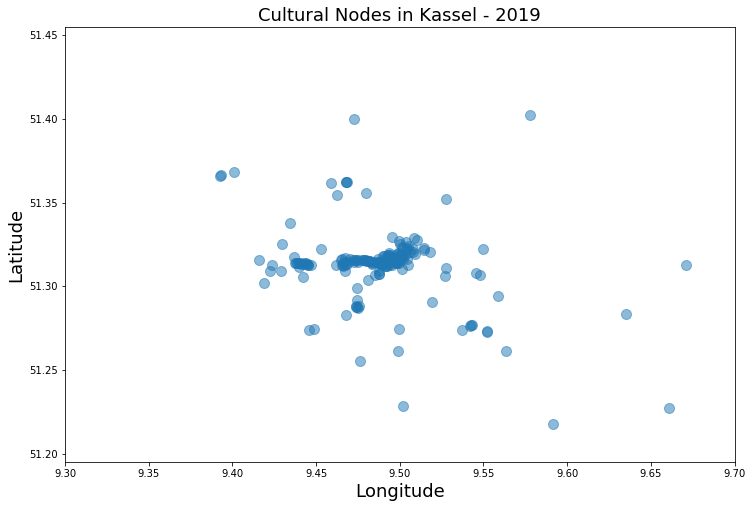

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib    

# plot all coordinates together in one colour

coord_array = np.array(all_coords)

plt.plot(coord_array[:, 0], coord_array[:, 1], 'o', alpha = 0.5, markersize=10)

plt.title('Cultural Nodes in Kassel - 2019', size = 18)
plt.xlabel('Longitude', size = 18)
plt.ylabel('Latitude', size = 18)
plt.axis('equal')
plt.gca().set_ylim(51.2, 51.45)
plt.gca().set_xlim(9.3, 9.7)

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(12, 8)
fig.savefig('2019_culture_kassel.png', dpi=100)

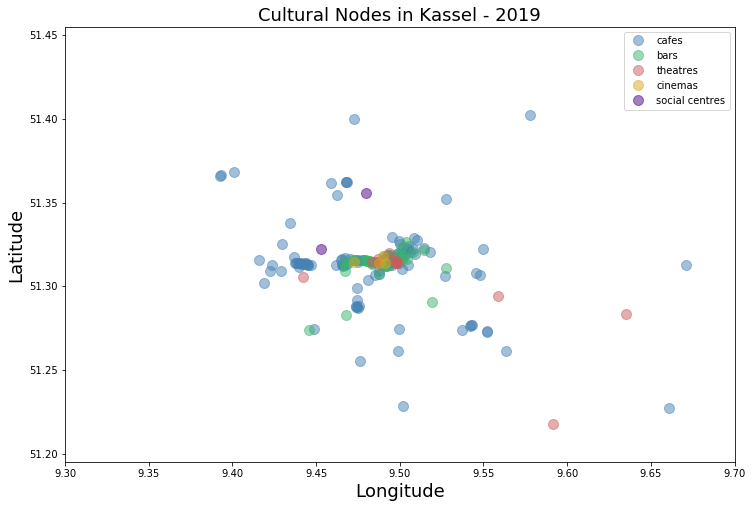

In [5]:
# now plot cultural nodes for different anemities

a = np.array(coord_list_cafes)
b = np.array(coord_list_bars)
c = np.array(coord_list_theatres)
d = np.array(coord_list_cinemas)
e = np.array(coord_list_social_centres)

plt.plot(a[:, 0], a[:, 1], 'o', color = 'steelblue', label="cafes", alpha = 0.5, markersize=10)
plt.plot(b[:, 0], b[:, 1], 'o', color = 'mediumseagreen' ,label="bars", alpha = 0.5, markersize=10)
plt.plot(c[:, 0], c[:, 1], 'o', color = 'indianred', label="theatres", alpha = 0.5, markersize=10)
plt.plot(d[:, 0], d[:, 1], 'o', color = 'goldenrod', label="cinemas", alpha = 0.5, markersize=10)
plt.plot(e[:, 0], e[:, 1], 'o', color = 'indigo', label="social centres", alpha = 0.5, markersize=10)

plt.title('Cultural Nodes in Kassel - 2019', size = 18)
plt.xlabel('Longitude', size = 18)
plt.ylabel('Latitude', size = 18)
plt.legend()
plt.axis('equal')
plt.gca().set_ylim(51.2, 51.45)
plt.gca().set_xlim(9.3, 9.7)

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(12, 8)
fig.savefig('2019_culture_kassel_types.png', dpi=100)

# Historical OSM Data ... or how it COULD work

#### a) Overpass API

use the compare() or retro() arguments in overpass API query - but HOW?!

unsuccessful attempt, see last cell

#### b) Osmium

data from: http://odbl.poole.ch/extracts/

download Germany extract: http://odbl.poole.ch/extracts/ - 3GB .osh.bz2 file and unpack... --> Error "you ran out of disk space!"

see 3 cells below (what I could use...)

https://github.com/osmcode/pyosmium


#### c) Osmconvert 

data from: http://odbl.poole.ch/extracts/

download Germany extract: http://odbl.poole.ch/extracts/ - 3GB .osh.bz2 file and unpack... (same as above)

seems like the simpler approach

https://wiki.openstreetmap.org/wiki/Osmconvert

run osmconvert in terminal

* osmconvert germany.osh >germany.osm

* osmconvert germany.osm -B=kassel.poly -o=kassel.osm

* osmconvert kassel.osm --all-to-nodes -o=kassel_nodes.osm

* osmconvert culture_kassel.osm --all-to-nodes --csv="@id @lon @lat amenity name" --csv-headline

In [7]:
"""
Converts a file from one format to another.
This example shows how to write objects to a file.
"""

import osmium as o
import sys

class Convert(o.SimpleHandler):

    def __init__(self, writer):
        super(Convert, self).__init__()
        self.writer = writer

    def node(self, n):
        self.writer.add_node(n)

    def way(self, w):
        self.writer.add_way(w)

    def relation(self, r):
        self.writer.add_relation(r)

if __name__ == '__main__':
    if len(sys.argv) != 3:
        print("Usage: python convert.py <infile> <outfile>")
        sys.exit(-1)

    writer = o.SimpleWriter(sys.argv[2])
    handler = Convert(writer)

    handler.apply_file(sys.argv[1])

    writer.close()

RuntimeError: Can not open file '/Users/lisaoswald/Library/Jupyter/runtime/kernel-271b63c4-905c-448b-83ab-9ee9b04523a9.json' with type 'JSON'. No support for writing this format in this program.

In [8]:
"""
Extract all objects with an amenity tag from an osm file and list them
with their name and position.
This example shows how geometries from osmium objects can be imported
into shapely using the WKBFactory.
"""
import osmium as o
import sys
import shapely.wkb as wkblib

wkbfab = o.geom.WKBFactory()

class AmenityListHandler(o.SimpleHandler):

    def print_amenity(amenity, tags, lon, lat):
        name = tags.get('name', '')
        print("%f %f %-15s %s" % (lon, lat, tags['amenity'], name))

    def node(self, n):
        if 'amenity' in n.tags:
            self.print_amenity(n.tags, n.location.lon, n.location.lat)

    def area(self, a):
        if 'amenity' in a.tags:
            wkb = wkbfab.create_multipolygon(a)
            poly = wkblib.loads(wkb, hex=True)
            centroid = poly.representative_point()
            self.print_amenity(a.tags, centroid.x, centroid.y)


def main(osmfile):

    handler = AmenityListHandler()

    handler.apply_file(osmfile)

    return 0

if __name__ == '__main__':
    if len(sys.argv) != 2:
        print("Usage: python %s <osmfile>" % sys.argv[0])
        sys.exit(-1)

    exit(main(sys.argv[1]))

ModuleNotFoundError: No module named 'shapely'

In [9]:
"""
Search for pubs in an osm file and list their names.
"""
import osmium
import sys

class NamesHandler(osmium.SimpleHandler):

    def output_pubs(self, tags):
        if tags.get('amenity') == 'pub':
            if 'name' in tags:
                print(tags['name'])

    def node(self, n):
        self.output_pubs(n.tags)

    def way(self, w):
        self.output_pubs(w.tags)

def main(osmfile):
    NamesHandler().apply_file(osmfile)

    return 0

if __name__ == '__main__':
    if len(sys.argv) != 2:
        print("Usage: python %s <osmfile>" % sys.argv[0])
        sys.exit(-1)

    exit(main(sys.argv[1]))

Usage: python /anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py <osmfile>


SystemExit: -1

/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3304: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [10]:
# initial try to get historical data within overpass API query


def getObjects(x):
    overpass_url = "http://overpass-api.de/api/interpreter"
    try:
        overpass_query ="""
        
        [out:csv(version,timestamp,changeset,count)];
        
        timeline(;
        area[name="Kassel"][type="boundary"];
        (node["amenity"={}](area);
        way["amenity"={}](area);
        rel["amenity"={}](area);
        );
        );
        for (t["created"])
        {
          retro(_.val)
          {
        area[name="Kassel"][type="boundary"];
        (node["amenity"={}](area);
        way["amenity"={}](area);
        rel["amenity"={}](area);
        );
        make stat version=u(version()),timestamp=u(timestamp()),changeset=u(changeset()),count=u(count_members());
        out;
          }
        }
    
        [out:json];

        """.format(x,x,x,x,x,x)
        response_json = requests.get(overpass_url, params = {'data': overpass_query})
        return response_json
    except:
        pass

objects = ["art_centre", "bar", "cafe", "cinema", "night_club", "social_centre", "theatre"]
alldata = []

for i in objects:
    try:
        response_json = getObjects(i)
        data = response_json.json()
        alldata.append(data)
    except:
        pass

    